## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv('../data/patient_processed.csv')
# Select the relevant columns
features = data[['tanimoto', 'feature_jsim', 'feature_dsim', 'feature_osim']]
labels = data['DDI']

# Map DDI levels to the numeric values
ddi_mapping = {'no interaction found': 0, 'minor': 1, 'moderate': 2, 'major': 3}
labels = labels.map(ddi_mapping)

# Handle missing values
features = features.fillna(features.mean())

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the target variable to a categorical format
num_classes = len(ddi_mapping)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Function for augmenting the data
def augment_data(X, y, num_samples):
    X_aug, y_aug = resample(X, y, n_samples=num_samples, random_state=42)
    return X_aug, y_aug

# Augment the training data
X_train_aug, y_train_aug = augment_data(X_train_scaled, y_train_cat, len(X_train_scaled) * 2)

# Combine original and augmented data
X_train_scaled = np.vstack((X_train_scaled, X_train_aug))
y_train_cat = np.vstack((y_train_cat, y_train_aug))

## Define Hyperparameters

In [2]:
# Model Hypeparameters
num_features = len(ddi_mapping)
num_classes = X_train_scaled.shape[1]
learning_rate = 0.001
batch_size = 32
epochs = 100

# Privacy Hyperparameters
l2_norm_clip = 1.0
noise_multiplier = 1.1
num_microbatches = 1

## Build and Compile the Models

### Model Architecture

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from keras.regularizers import l2

def create_model(num_features, num_classes, noise_multiplier = 1.1, learning_rate = learning_rate, optimizer=None):
    """
    This function creates a deep learning model with three hidden layers and applies differential privacy
    using a differentially private SGD optimizer.

    Input:
    num_features: The number of input features for the model.
    num_classes: The number of output classes for classification.
    noise_multiplier: The noise multiplier used for differential privacy (default is 1.1).
    learning_rate: The learning rate for the optimiser.
    optimiser: The optimiser used to trained the model

    Output:
    A compiled TensorFlow model ready for training.

    """
    
    model = keras.Sequential([
        keras.layers.Input(shape=(num_features,)),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        #keras.layers.BatchNormalization(),
        #keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    if optimizer is None: 
        optimizer = DPKerasSGDOptimizer(
                l2_norm_clip=l2_norm_clip,
                noise_multiplier=noise_multiplier,
                num_microbatches=num_microbatches,
                learning_rate=learning_rate
            )
    
    model.compile(
        optimizer = optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Differential Privacy Model

#### Model Training

In [6]:
# Build a model with differential privacy
model_dp = create_model(num_features, num_classes)

# Use callbacks for early stopping and learning rate scheduling
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Train the model
history = model_dp.fit(
    X_train_scaled, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks =[early_stopping, lr_scheduler]
)


Epoch 1/100

13/13 [==============================] - 3s 25ms/step - loss: 1.5290 - accuracy: 0.0412 - val_loss: 1.5327 - val_accuracy: 0.0510 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 1.5191 - accuracy: 0.0412 - val_loss: 1.5216 - val_accuracy: 0.0510 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 1.5069 - accuracy: 0.0438 - val_loss: 1.5010 - val_accuracy: 0.0714 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 1.4904 - accuracy: 0.0928 - val_loss: 1.4897 - val_accuracy: 0.0918 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 1.4778 - accuracy: 0.2113 - val_loss: 1.4717 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 1.4671 - accuracy: 0.3402 - val_loss: 1.4663 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - lo

#### Model Evaluation

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model):

    # Making Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Calculating the metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # Printing out metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [22]:
evaluate(model_dp)

2/2 [==============================] - 0s 4ms/step
Accuracy: 0.8537
Precision: 0.2134
Recall: 0.8537
F1 Score: 0.2303


c:\Users\chery\anaconda3\envs\fyp1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


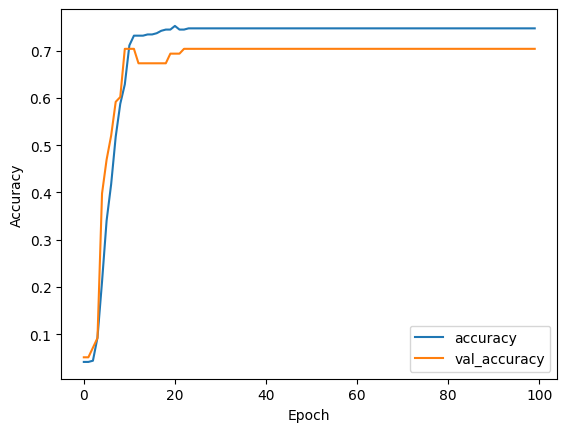

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Non-Differential Privacy Model

In [10]:
from keras.optimizers import SGD

sgd = SGD(learning_rate=learning_rate, momentum=momentum)

model = create_model(num_features, num_classes, optimizer=sgd)

history = model.fit(
    X_train_combined, y_train_combined,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks =[early_stopping, lr_scheduler]
)

Epoch 1/100
13/13 [==============================] - 2s 28ms/step - loss: 1.4548 - accuracy: 0.4742 - val_loss: 1.4385 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 1.4144 - accuracy: 0.7423 - val_loss: 1.3956 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 1.3649 - accuracy: 0.7371 - val_loss: 1.3455 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 1.3116 - accuracy: 0.7371 - val_loss: 1.2965 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 1.2606 - accuracy: 0.7371 - val_loss: 1.2507 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 1.2122 - accuracy: 0.7474 - val_loss: 1.2076 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 1

In [23]:
# Evaluate the model
evaluate(model)

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.8537
Precision: 0.3429
Recall: 0.8537
F1 Score: 0.3297


c:\Users\chery\anaconda3\envs\fyp1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


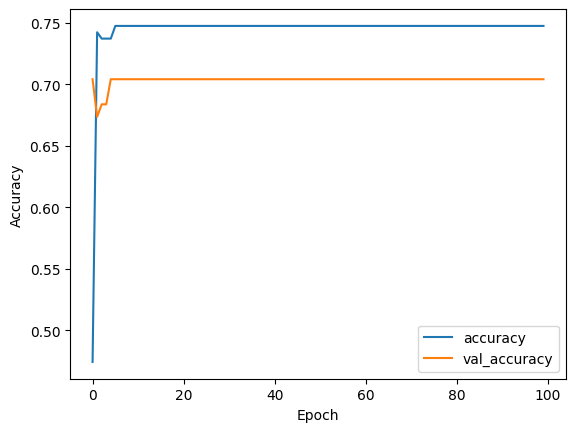

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Saving Models

In [ ]:
model_dp.save('src/model')

### Evaluating Privacy

#### Evaluating Privacy Budget

In [13]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

epsilon, alpha = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=X_train.shape[0],
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=epochs,
    delta=1e-5
)

print(f"The privacy budget (epsilon) is: {epsilon}")

The privacy budget (epsilon) is: 34.93366614527281


#### Observing Privacy-Utility Tradeoff

In [14]:
noise_multipliers = [0.1, 0.5, 1.0, 2.0]
results = []

for noise_multiplier in noise_multipliers:
    
    print(f"\nTraining with noise multiplier: {noise_multiplier}")
    
    # Create the model
    model = create_model(num_features, num_classes, noise_multiplier)
    
    # Train the model
    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    
    # Calculate epsilon
    epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
        n=len(X_train),
        batch_size=batch_size,
        noise_multiplier=noise_multiplier,
        epochs=epochs,
        delta=1e-5
    )
    
    results.append({
        'noise_multiplier': noise_multiplier,
        'test_accuracy': test_accuracy,
        'epsilon': epsilon
    })
    
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Epsilon: {epsilon:.4f}")
    
# Display results
for result in results:
    print(f"\nNoise Multiplier: {result['noise_multiplier']}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Epsilon: {result['epsilon']:.4f}")


Training with noise multiplier: 0.1


Test accuracy: 0.8293
Epsilon: 27619.6354

Training with noise multiplier: 0.5


Test accuracy: 0.8537
Epsilon: 182.7467

Training with noise multiplier: 1.0


Test accuracy: 0.8537
Epsilon: 43.0273

Training with noise multiplier: 2.0


Test accuracy: 0.8537
Epsilon: 13.5931

Noise Multiplier: 0.1
Test Accuracy: 0.8293
Epsilon: 27619.6354

Noise Multiplier: 0.5
Test Accuracy: 0.8537
Epsilon: 182.7467

Noise Multiplier: 1.0
Test Accuracy: 0.8537
Epsilon: 43.0273

Noise Multiplier: 2.0
Test Accuracy: 0.8537
Epsilon: 13.5931


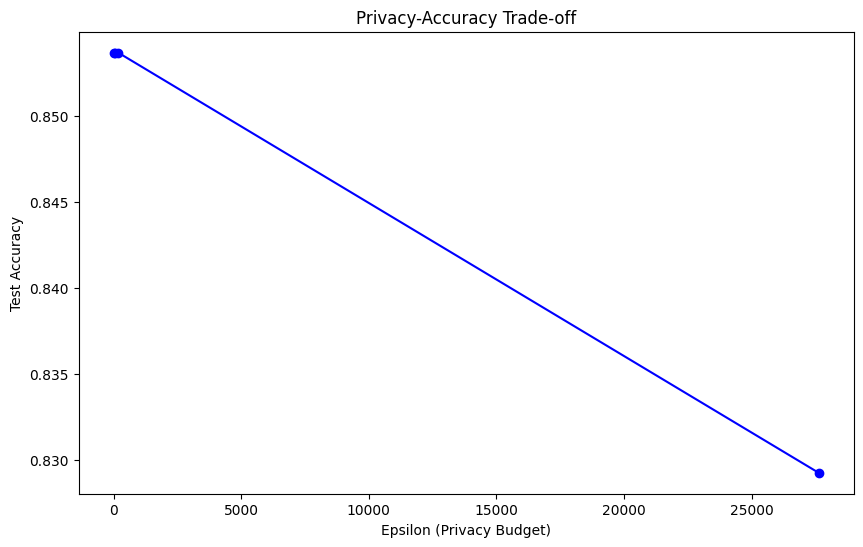

In [15]:
import matplotlib.pyplot as plt

epsilons = [result['epsilon'] for result in results]
accuracies = [result['test_accuracy'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, 'bo-')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Test Accuracy')
plt.title('Privacy-Accuracy Trade-off')
plt.show()